In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# File system manangement
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Training Data

train = pd.read_csv('train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training data has 891 observations and 12 features (variables) including the TARGET (the label we want to predict).In this case we want to predict whether a passenger on Titanic survived or not.

In [ ]:
# Testing data features
test = pd.read_csv('test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#Exploratory Data Analysis(EDA)

In [ ]:
#Examining the Distribution of the Target Column

train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

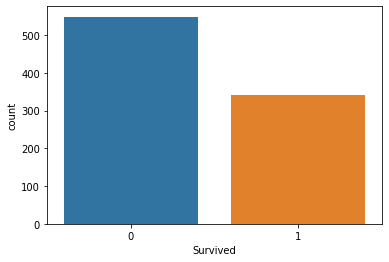

In [ ]:
sns.countplot(x = 'Survived',data = train)

Thus, around 549 people perished while 342 survived.

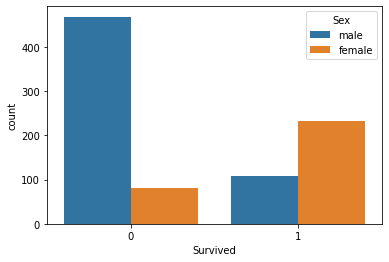

In [ ]:
sns.countplot(x = 'Survived',hue = 'Sex',data = train)

We can see that females survived in much higher proportions than males did. Now, Let’s see how many people survived divided by class.

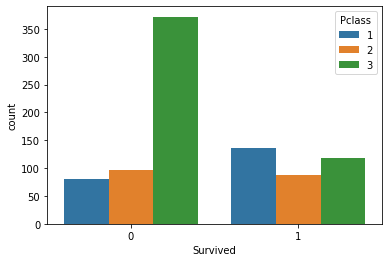

In [ ]:
sns.countplot(x = 'Survived',hue = 'Pclass',data = train)

Distribution of survival rate class wise

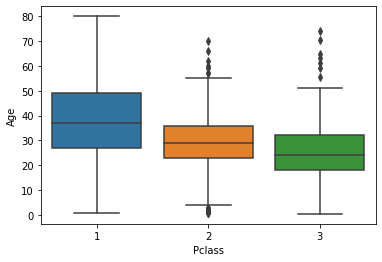

In [ ]:
sns.boxplot(x='Pclass',y='Age',data=train)

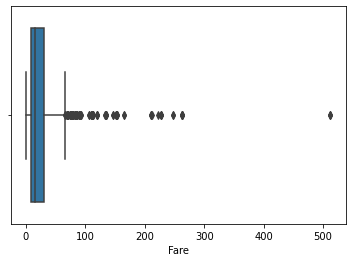

In [ ]:
sns.boxplot(train['Fare'],data=train)

#Examining Missing Values
Next we can look at the number and percentage of missing values in each column.

In [ ]:
print("Null in Training set")
print("---------------------")
print(train.isnull().sum())
print("---------------------")
print("Null in Testing set")
print("---------------------")
print(test.isnull().sum())

Null in Training set
---------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------------
Null in Testing set
---------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


The three columns i.e Age, cabin and Embarked have missing values which needs to be taken care of.

#1. Age Column
Let’s create a function to impute ages regarding the corresponding age average per class.

In [ ]:
def add_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return int(train[train["Pclass"] == Pclass]["Age"].mean())
    else:
        return Age

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(add_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(add_age,axis=1)

# 2. Missing values in Cabin
Since we have lots of null values for Cabin column, so it is better to remove it.

In [ ]:
train.drop("Cabin",inplace=True,axis=1)
test.drop("Cabin",inplace=True,axis=1)

KeyError: ignored

# 4. Missing values in Embarked column
Since there are just two missing values, we shall impute them with the mode of the Embarked column.

In [ ]:
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

# 5. Missing values in Fare column in Test Dataset
Since there is one missing value, we shall impute them with the mean of the Fare column.

In [ ]:
test['Fare'].fillna(test['Fare'].mean(),inplace=True)

# Creating new Features
WE shall create a new column called Family by combining Parch and SibSp columns

In [ ]:
def combine(df,col1,col2):
    df["Family"] = df[col1]+df[col2]
    df.drop([col1,col2],inplace=True,axis=1)
    return df

train = combine(train,'SibSp','Parch')
test = combine(test,'SibSp','Parch')

# **Outliers Analysis**

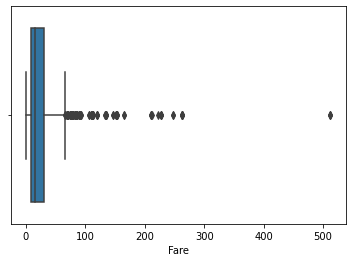

In [ ]:
sns.boxplot(train['Fare'],data=train)

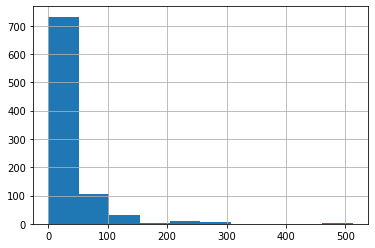

In [ ]:
train['Fare'].hist()

# **Skewness of fare**

In [ ]:
print('Skewnees of Fare',train['Fare'].skew())

Skewnees of Fare 4.787316519674893


# Interquartile range **IQR**

In [ ]:
Q1=train['Fare'].quantile(0.25)
Q3=train['Fare'].quantile(0.75)
IQR=Q3-Q1


# **We will deerimine outliers in fare**

In [ ]:
whisker_width=1.5
fare_outliers=train[(train['Fare']<Q1-whisker_width*IQR)  | (train['Fare']>Q3+whisker_width*IQR)]
fare_outliers.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Family
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,19950,263.0000,S,5
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,38.0,PC 17569,146.5208,C,1
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,PC 17604,82.1708,C,1
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,PC 17572,76.7292,C,1


# Will use capping and **flooring**

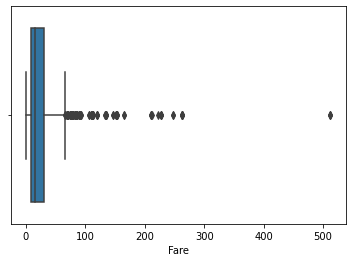

In [ ]:
sns.boxplot(train['Fare'],data=train)

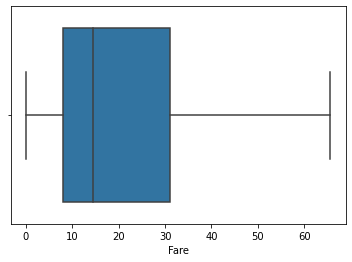

In [ ]:
train1=train.copy()
low=Q1-whisker_width*IQR
high=Q3+whisker_width*IQR
train1['Fare']=np.where(train1['Fare']>high,high,np.where(train['Fare']<low,low,train1['Fare']))

sns.boxplot(train1['Fare'],data=train1)

now if we compare the box plot for the fare column we will see that after capping and flooring the outliers have been replaced

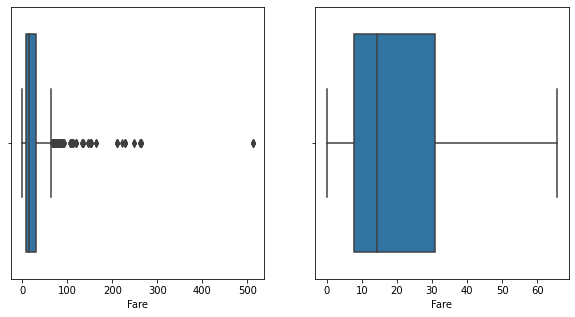

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(train['Fare'],data=train)
plt.subplot(1,2,2)
sns.boxplot(train1['Fare'],data=train1)

# Let’s take a look at the Age column

In [ ]:
train['Age'].describe()

count    891.000000
mean      29.252716
std       13.211959
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

# the Age column needs to be treated slightly differently, as this is a continuous numerical column.we can separate this continuous feature into a categorical feature by dividing it into ranges.

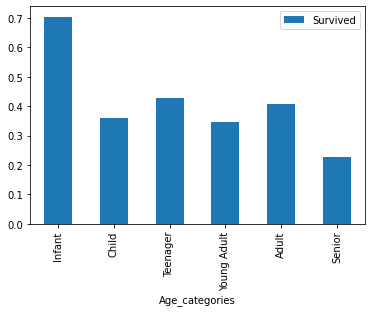

In [ ]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()

# Encoding Categorical Variables

We can use the pandas.get_dummies() function Now, we shall have to encode Sex, Embarked, Pclass and Age_categories. Name and Ticket columns have a lot of categories, hence we shall delete them.

In [ ]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories",'Embarked']:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

# Dropping Unnecessary columns

In [ ]:
train.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)
test.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)

# Logistic Regression Implementation

In [ ]:
lr1 = LogisticRegression()
columns = ['PassengerId', 'Age', 'Fare','Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr1.fit(train[columns], train["Survived"])

LogisticRegression()

# **implementing model without age column**

In [ ]:
train2=train.copy()
test2=test.copy()
train2.info()
test2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PassengerId                 891 non-null    int64  
 1   Survived                    891 non-null    int64  
 2   Age                         891 non-null    float64
 3   Fare                        891 non-null    float64
 4   Family                      891 non-null    int64  
 5   Pclass_1                    891 non-null    uint8  
 6   Pclass_2                    891 non-null    uint8  
 7   Pclass_3                    891 non-null    uint8  
 8   Sex_female                  891 non-null    uint8  
 9   Sex_male                    891 non-null    uint8  
 10  Age_categories_Missing      891 non-null    uint8  
 11  Age_categories_Infant       891 non-null    uint8  
 12  Age_categories_Child        891 non-null    uint8  
 13  Age_categories_Teenager     891 non

In [ ]:
train2.drop(['Age'],inplace=True,axis=1)
test2.drop(['Age'],inplace=True,axis=1)

In [ ]:
lr = LogisticRegression()
columns = ['PassengerId', 'Fare','Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr.fit(train2[columns], train2["Survived"])

LogisticRegression()

In [ ]:
x=train2[columns]
y=train2['Survived']


In [ ]:
lr = LogisticRegression()
lr.fit(x, y)
predictions = lr.predict(x)
accuracy = accuracy_score(y, predictions)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(y,predictions))

0.8204264870931538
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       549
           1       0.79      0.73      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



# Evaluating Accuracy of our model

Creating a Validation set
We will hold out a part of the training set during the start of the experiment and use it for evaluating our predictions. We shall use the scikit-learn library's model_selection.train_test_split() function that we can use to split our data

In [ ]:
X = train[columns]
y = train['Survived']

train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.20,random_state=0)

## **my version with 100% train data**

In [ ]:
x1=train[columns]
y1=train['Survived']


In [ ]:
lr2 = LogisticRegression()
lr.fit(x1, y1)
predictions = lr.predict(x1)
accuracy = accuracy_score(y1, predictions)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(y,predictions))

0.8204264870931538
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       549
           1       0.79      0.73      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



# Making predictions and measuring accuracy

In [ ]:
lr1 = LogisticRegression()
lr1.fit(train_X, train_y)
predictions = lr1.predict(val_X)
accuracy = accuracy_score(val_y, predictions)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(val_y,predictions))

0.8268156424581006
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



# Making Predictions on Test data

In [ ]:
lr = LogisticRegression()
lr.fit(X,y)
predictions_test = lr.predict(test[columns])

In [ ]:
print(predictions_test)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]
